In [12]:
import gym
import numpy as np
import tiles3 as tc
import matplotlib.pyplot as plt

In [2]:
def argmax(q_values):
    top = float("-inf")
    ties = []

    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = []

        if q_values[i] == top:
            ties.append(i)

    return np.random.choice(ties)

In [6]:
class CartPoleTileCoder:
    def __init__(self, iht_size=4096, num_tilings=8, num_tiles=8):
        """
        Initializes the MountainCar Tile Coder
        Initializers:
        iht_size -- int, the size of the index hash table, typically a power of 2
        num_tilings -- int, the number of tilings
        num_tiles -- int, the number of tiles. Here both the width and height of the
                     tile coder are the same
        Class Variables:
        self.iht -- tc.IHT, the index hash table that the tile coder will use
        self.num_tilings -- int, the number of tilings the tile coder will use
        self.num_tiles -- int, the number of tiles the tile coder will use
        """
        self.iht = tc.IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
    
    def get_tiles(self, position, velocity, angle, angular_vel):
        """
        Takes in a position and velocity from the mountaincar environment
        and returns a numpy array of active tiles.
        
        Arguments:
        position -- float, the position of the agent between -1.2 and 0.5
        velocity -- float, the velocity of the agent between -0.07 and 0.07
        returns:
        tiles - np.array, active tiles
        """

        POSITION_MIN = -4.8
        POSITION_MAX = 4.8
        VELOCITY_MIN = -2
        VELOCITY_MAX = 2
        POLE_ANGLE_MIN = -0.418
        POLE_ANGLE_MAX = 0.418
        POLE_ANG_VEL_MIN = -2
        POLE_ANG_VEL_MAX = 2

        position_scale = self.num_tiles / (POSITION_MAX - POSITION_MIN)
        velocity_scale = self.num_tiles / (VELOCITY_MAX - VELOCITY_MIN)
        pole_angle_scale = self.num_tiles / (POLE_ANGLE_MAX - POLE_ANGLE_MIN)
        pole_angle_velocity_scale = self.num_tiles / (POLE_ANG_VEL_MAX - POLE_ANG_VEL_MIN)

        tiles = tc.tiles(self.iht, self.num_tilings, [position * position_scale, 
                                                      velocity * velocity_scale,
                                                      angle * pole_angle_scale,
                                                      angular_vel * pole_angle_velocity_scale])
        
        return np.array(tiles)

In [7]:
class SarsaAgent:
    
    num_tilings = 8
    num_tiles = 8
    iht_size = 4096 # index hash table
    
    # learning rate
    alpha = 0.5 / num_tilings
    # how often random move
    epsilon = 0.1
    # discount future rewards
    gamma = 1
    
    

    def __init__(self, action_space, observation_space):

        self.action_space = action_space
        
        # initialize value-function weights w
        self.w = np.ones((action_space.n, self.iht_size))
        
        # initialize tilecoder
        self.tc = CartPoleTileCoder(iht_size=self.iht_size, 
                                       num_tilings=self.num_tilings, 
                                       num_tiles=self.num_tiles)
        
        self.previous_tiles = None
        
        # initialize state, action and reward
        #self.s = self.a = self.r = None
    
    def select_initial_action(self, state):
        position, velocity, angle, angular_vel = state
        
        active_tiles = self.tc.get_tiles(position, velocity, angle, angular_vel)
        action, action_value = self.select_action(active_tiles)
        
        self.previous_tiles = np.copy(active_tiles)
        
        return action

    def select_action(self, tiles):
        action_values = []
        action = None
        # First loop through the weights of each action and populate action_values
        # with the action value for each action and tiles instance
        for w in self.w:
            action_values.append(sum(w[tiles]))
        # Epsilon-greedy action selection
        if np.random.random() < self.epsilon:
            action = np.random.randint(len(action_values))
        else:
            action = argmax(action_values)
        
        #print("tiles", tiles, "action_values", action_values)
        #print("weights", self.w)
        
        return action, action_values[action]

    def observe(self, state, action, reward, next_state, done):
            #input()
            #print("state", state, "action", action, "reward", reward, "next_state", next_state)
            if done:
                target = reward
                estimate = sum(self.w[action][self.previous_tiles])
                self.w[action][self.previous_tiles] += self.alpha * (target - estimate)
                return None
            else:
                position, velocity, angle, angular_vel = next_state
                active_tiles = self.tc.get_tiles(position, velocity, angle, angular_vel)
                
                next_action, action_value = self.select_action(active_tiles)
                
                target = reward + self.gamma * action_value
                estimate = sum(self.w[action][self.previous_tiles])
                # print("loss", target - estimate)
                
                self.w[action][self.previous_tiles] += self.alpha * (target - estimate)
                
                self.previous_tiles = np.copy(active_tiles)
            return next_action
        

In [26]:
env = gym.make('CartPole-v0')
env = env.unwrapped
agent = SarsaAgent(env.action_space, env.observation_space)

total_rewards = []

for i_episode in range(1000):
    # choose inital state and action
    state = env.reset()
    action = agent.select_initial_action(state)
    total_reward = 0
    
    for t in range(10000):
        # env.render()
        # Take action and observe reward, next_state
        next_state, reward, done, info = env.step(action)
        action = agent.observe(state, action, reward, next_state, done)
        total_reward += reward
        if done:
            break
        state = next_state
    print("Episode finished after {} timesteps with reward {}".format(t+1, total_reward))
    total_rewards.append(total_reward)
    #if i_episode >= 100 and np.mean(total_rewards[-100:]) > 195:
    #    print("Solved, episode", i_episode)
    #    break
    
env.close()

np.mean(total_rewards[-100:])

Episode finished after 28 timesteps with reward 28.0
Episode finished after 46 timesteps with reward 46.0
Episode finished after 168 timesteps with reward 168.0
Episode finished after 91 timesteps with reward 91.0
Episode finished after 88 timesteps with reward 88.0
Episode finished after 159 timesteps with reward 159.0
Episode finished after 77 timesteps with reward 77.0
Episode finished after 109 timesteps with reward 109.0
Episode finished after 120 timesteps with reward 120.0
Episode finished after 42 timesteps with reward 42.0
Episode finished after 158 timesteps with reward 158.0
Episode finished after 104 timesteps with reward 104.0
Episode finished after 191 timesteps with reward 191.0
Episode finished after 182 timesteps with reward 182.0
Episode finished after 136 timesteps with reward 136.0
Episode finished after 62 timesteps with reward 62.0
Episode finished after 160 timesteps with reward 160.0
Episode finished after 184 timesteps with reward 184.0
Episode finished after 8

Episode finished after 333 timesteps with reward 333.0
Episode finished after 296 timesteps with reward 296.0
Episode finished after 280 timesteps with reward 280.0
Episode finished after 308 timesteps with reward 308.0
Episode finished after 176 timesteps with reward 176.0
Episode finished after 359 timesteps with reward 359.0
Episode finished after 304 timesteps with reward 304.0
Episode finished after 796 timesteps with reward 796.0
Episode finished after 2397 timesteps with reward 2397.0
Episode finished after 678 timesteps with reward 678.0
Episode finished after 297 timesteps with reward 297.0
Episode finished after 646 timesteps with reward 646.0
Episode finished after 506 timesteps with reward 506.0
Episode finished after 3131 timesteps with reward 3131.0
Episode finished after 280 timesteps with reward 280.0
Episode finished after 767 timesteps with reward 767.0
Episode finished after 504 timesteps with reward 504.0
Episode finished after 740 timesteps with reward 740.0
Episod

Episode finished after 10000 timesteps with reward 10000.0
Episode finished after 3220 timesteps with reward 3220.0
Episode finished after 10000 timesteps with reward 10000.0
Episode finished after 10000 timesteps with reward 10000.0
Episode finished after 10000 timesteps with reward 10000.0
Episode finished after 10000 timesteps with reward 10000.0
Episode finished after 7277 timesteps with reward 7277.0
Episode finished after 10000 timesteps with reward 10000.0
Episode finished after 10000 timesteps with reward 10000.0
Episode finished after 1933 timesteps with reward 1933.0
Episode finished after 6258 timesteps with reward 6258.0
Episode finished after 1656 timesteps with reward 1656.0
Episode finished after 10000 timesteps with reward 10000.0
Episode finished after 2270 timesteps with reward 2270.0
Episode finished after 6091 timesteps with reward 6091.0
Episode finished after 1477 timesteps with reward 1477.0
Episode finished after 8368 timesteps with reward 8368.0
Episode finishe

KeyboardInterrupt: 

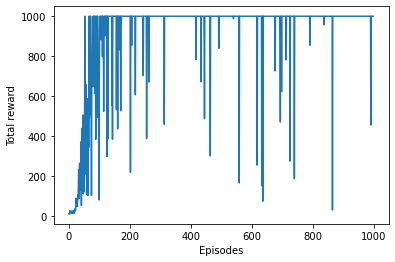

In [20]:
plt.plot(total_rewards)
plt.ylabel('Total reward')
plt.xlabel('Episodes')
plt.show()

In [ ]:
total_rewards = []

for i_episode in range(10):
    # choose inital state and action
    state = env.reset()
    action = agent.select_initial_action(state)
    total_reward = 0
    
    for t in range(10000):
        env.render()
        # Take action and observe reward, next_state
        next_state, reward, done, info = env.step(action)
        action = agent.observe(state, action, reward, next_state, done)
        total_reward += reward
        if done:
            break
        state = next_state
    
    total_rewards.append(total_reward)
    print("Episode finished after {}".format(t+1))
    
    
np.mean(total_rewards)
    
env.close()

Episode finished after 10000
Episode finished after 10000
Episode finished after 2679
Episode finished after 10000
Episode finished after 10000


In [23]:
import gym
env = gym.make('CartPole-v0')
for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        env.render()
        print(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

[ 0.0007741   0.0099058  -0.03934276  0.03623549]
[ 0.00097222 -0.18463053 -0.03861805  0.3162504 ]
[-0.00272039  0.0110196  -0.03229304  0.01164312]
[-0.0025     -0.1836247  -0.03206018  0.29396484]
[-0.0061725   0.01193932 -0.02618088 -0.00865452]
[-0.00593371  0.20742677 -0.02635397 -0.3094815 ]
[-0.00178517  0.4029141  -0.0325436  -0.61035785]
[ 0.00627311  0.2082618  -0.04475076 -0.32810012]
[ 0.01043834  0.01380456 -0.05131276 -0.04985862]
[ 0.01071444  0.2096233  -0.05230993 -0.35827946]
[ 0.0149069   0.40544837 -0.05947552 -0.66698737]
[ 0.02301587  0.60134483 -0.07281527 -0.977788  ]
[ 0.03504277  0.40727077 -0.09237103 -0.70883709]
[ 0.04318818  0.21354142 -0.10654777 -0.44660041]
[ 0.04745901  0.40999662 -0.11547978 -0.77087791]
[ 0.05565894  0.60650234 -0.13089734 -1.09754893]
[ 0.06778899  0.41332369 -0.15284832 -0.84863389]
[ 0.07605546  0.61016288 -0.16982099 -1.185213  ]
[ 0.08825872  0.80703069 -0.19352525 -1.52595456]
Episode finished after 19 timesteps
[-0.02434426  

[-0.05364937 -0.02818791 -0.00855454 -0.02818849]
[-0.05421313  0.16705567 -0.00911831 -0.32355815]
[-0.05087202 -0.02793526 -0.01558947 -0.03376465]
[-0.05143072  0.16740674 -0.01626477 -0.33132517]
[-0.04808259 -0.02747997 -0.02289127 -0.04381541]
[-0.04863219 -0.22226631 -0.02376758  0.24155811]
[-0.05307751 -0.41704083 -0.01893642  0.52665037]
[-0.06141833 -0.22165762 -0.00840341  0.22806112]
[-0.06585148 -0.02641659 -0.00384219 -0.06726066]
[-0.06637981  0.16876023 -0.0051874  -0.36115333]
[-0.06300461 -0.0262876  -0.01241047 -0.07011061]
[-0.06353036 -0.22122945 -0.01381268  0.21863106]
[-0.06795495 -0.0259128  -0.00944006 -0.07837676]
[-0.06847321  0.1693432  -0.01100759 -0.37402304]
[-0.06508634 -0.02562068 -0.01848805 -0.08483112]
[-0.06559876  0.16976134 -0.02018468 -0.38328924]
[-0.06220353 -0.02506829 -0.02785046 -0.09703821]
[-0.06270489 -0.21978024 -0.02979123  0.18672947]
[-0.0671005  -0.024245   -0.02605664 -0.11520057]
[-0.0675854  -0.2189841  -0.02836065  0.16914913]


[ 0.07654161  0.63722305 -0.13924232 -1.1549304 ]
[ 0.08928607  0.83385845 -0.16234092 -1.48783387]
[ 0.10596324  0.64104352 -0.1920976  -1.24993314]
Episode finished after 18 timesteps
[ 0.03998683 -0.02898917 -0.0340523   0.0179484 ]
[ 0.03940705 -0.22360665 -0.03369333  0.29969594]
[ 0.03493492 -0.02802104 -0.02769941 -0.00341993]
[ 0.0343745   0.16748698 -0.02776781 -0.30471205]
[ 0.03772424  0.36299342 -0.03386205 -0.60602134]
[ 0.0449841   0.16836092 -0.04598248 -0.3241935 ]
[ 0.04835132  0.36410642 -0.05246635 -0.63101548]
[ 0.05563345  0.55991966 -0.06508666 -0.9397492 ]
[ 0.06683184  0.75585573 -0.08388164 -1.25215296]
[ 0.08194896  0.95194616 -0.1089247  -1.56988671]
[ 0.10098788  0.7582801  -0.14032244 -1.31306983]
[ 0.11615348  0.56518538 -0.16658383 -1.0673942 ]
[ 0.12745719  0.37261164 -0.18793172 -0.83128174]
[ 0.13490942  0.18048662 -0.20455735 -0.60309567]
Episode finished after 14 timesteps
[ 0.01984832 -0.02518923  0.03476664  0.00900532]
[ 0.01934453 -0.22079209  0.